This code is from the documentation of [scikit survival on Cox model penalized](https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html). The target of this subject is to understand the implementation and the analysis.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import warnings

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
set_config(display="text")  # displays text representation of estimators
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)

We load the data about cancer and we transform features.
In this step, it is important to separate features and target.

In [3]:
X, y = load_breast_cancer()                 # features, target
Xt = OneHotEncoder().fit_transform(X)       # transform features
Xt.round(2).head()                          

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,er=positive,grade=intermediate,grade=poorly differentiated,grade=unkown,size
0,10.93,8.96,11.63,10.96,11.52,12.04,9.62,9.81,10.02,7.85,...,10.13,10.93,6.48,5.99,57.0,0.0,0.0,1.0,0.0,3.0
1,12.24,9.53,12.63,11.59,12.32,10.78,10.60,10.70,10.16,8.74,...,10.21,9.56,4.97,7.05,57.0,1.0,0.0,1.0,0.0,3.0
2,11.66,10.24,12.57,9.17,11.70,11.35,9.38,10.16,10.03,8.13,...,10.16,9.31,4.28,6.83,48.0,0.0,0.0,1.0,0.0,2.5
3,12.17,9.82,12.11,9.09,13.13,11.86,8.40,8.67,10.73,8.65,...,10.66,10.21,5.71,6.93,42.0,1.0,0.0,1.0,0.0,1.8
4,11.48,11.49,11.78,8.89,10.43,11.40,7.74,8.64,9.56,8.48,...,11.57,10.93,5.82,6.66,46.0,1.0,1.0,0.0,0.0,3.0


Looking for optimal hyperparameter $\alpha$ in Cox model for survival analysis. 

We follow the next step : 
1. Define a value scale for $\alpha$;
2. Initialize Cox model;
3. Find the best $\alpha$ looking over the scale.

At the end of the script, we convert this dictionnary of coefficients into dataframe. 

In [4]:
# grille de valeurs possible pour les hyperparamètres
alphas = 10.0 ** np.linspace(-4, 4, 50)
coefficients = {}

# initialisation du modèle de survie -- Modèle de Cox
cph = CoxPHSurvivalAnalysis()

# paramétrisation des coefficients
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

# création d'un dataframe à partir d'un coefficient
coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(Xt.columns)

Visualize the evolution of the coefficients by the differents values of $\alpha$. 

In [ ]:
# function to plot graph about the evolution of coefficients by alpha values
def plot_coefficients(coefs, n_highlight):
    '''
    Function to plot the convergence of coefficients by alpha
    
    Attributs
    ---------
    coefs : dataframe
        coefficients of survival model
    
    n_highlight : int
        
    '''
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

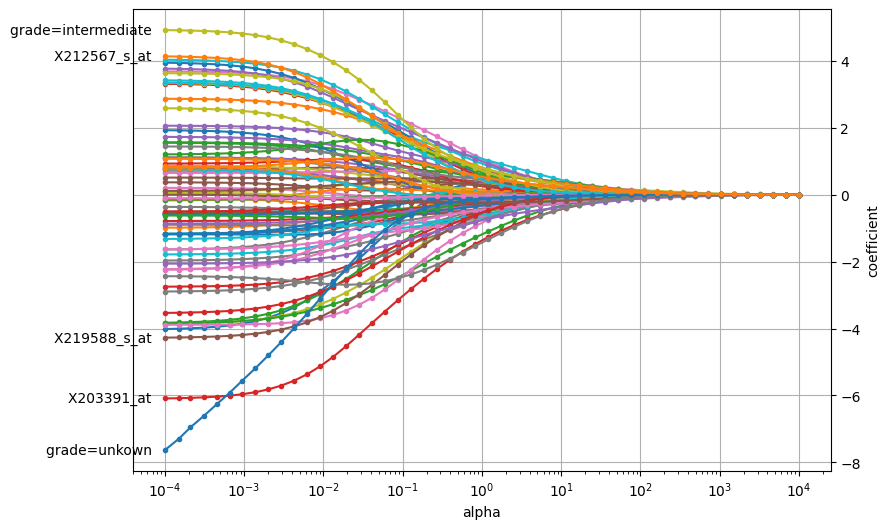

In [6]:
plot_coefficients(coefficients, n_highlight=5)

## Lasso

In this step, we apply an L1 regularization penalty to the Cox model. L1 regularization encourages coefficients for certain features to be reduced to zero, which can lead to a parsimonious model. 

In [7]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

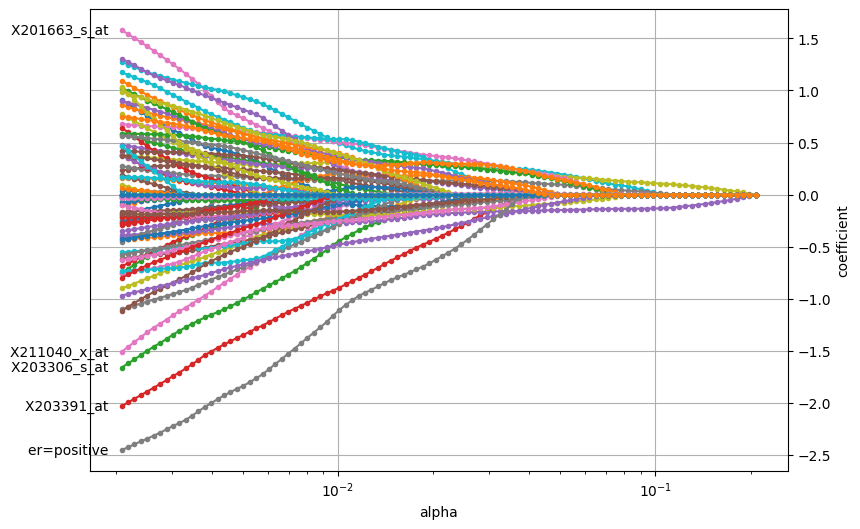

In [8]:
coefficients_lasso = pd.DataFrame(cox_lasso.coef_, index=Xt.columns, columns=np.round(cox_lasso.alphas_, 5))

plot_coefficients(coefficients_lasso, n_highlight=5)

## Elastic-net

In this step, we use Elastic-net : a mix of LASSO and RIDGE regularization. This combination allows a certain degree of variable selection while maintaining coefficient stability.

In [9]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01) # l1_ration = 0.9 implique que 90% de la régularisation sera applique à LASSO et 10% à Ridge
cox_elastic_net.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9)

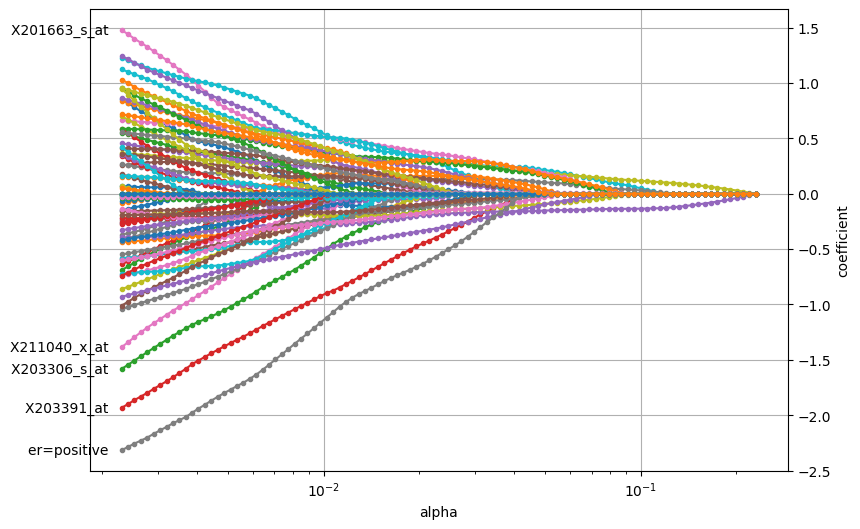

In [10]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)